## Prerequisites

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Dataset

In [2]:
from urllib.request import urlopen

target_url = 'https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt'
data = urlopen(target_url).read().decode('utf-8')

words = data.splitlines()

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
print(f'Total words in dataset={len(words)}')

Total words in dataset=32033


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build the dataset

In [6]:
# context length: how many characters do we take to predict the next one?
block_size = 3 


def build_dataset(words, purpose=''):  
  # inputs X
  # outputs, labels Y
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'{purpose} Dataset Input tensor{X.shape} of type{X.dtype}')
  print(f'{purpose} Dataset Output tensor{Y.shape} of type{Y.dtype}')
  return X, Y


In [7]:
X, Y = build_dataset(words, "Full")

Full Dataset Input tensortorch.Size([228146, 3]) of typetorch.int64
Full Dataset Output tensortorch.Size([228146]) of typetorch.int64


In [8]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Split the dataset into training, validation and test sets
Xtr, Ytr = build_dataset(words[:n1], "Training")
print()
Xdev, Ydev = build_dataset(words[n1:n2], "Validation")
print()
Xte, Yte = build_dataset(words[n2:], "Test")


Training Dataset Input tensortorch.Size([182625, 3]) of typetorch.int64
Training Dataset Output tensortorch.Size([182625]) of typetorch.int64

Validation Dataset Input tensortorch.Size([22655, 3]) of typetorch.int64
Validation Dataset Output tensortorch.Size([22655]) of typetorch.int64

Test Dataset Input tensortorch.Size([22866, 3]) of typetorch.int64
Test Dataset Output tensortorch.Size([22866]) of typetorch.int64


## Neural architecture

![Architecture](../../papers/bengio-neural-architecture.png)


- 3 previous words are inputs and the NN predicts the 4th word
- `C` is an embedding matrix or lookup table for vocabulary (rows) * vector dimensions (30,  60, 90..). Let's assume 30 dimensions to start.
- Every row corresponds to an embedding vector of X dimensions.
- `C` is shared across the input layer
- Input layer has 33 neurons for 3 words or block_size
- Next layer is a hidden layer. Size is a hyperparameter
- Tanh non-linearity as part of the hidden layer
- Output layer has logits of size of vocabulary. It is fully connected to the previous layer.
- Softmax is used here


## Matrix C for embeddings

In [9]:
# We're using a vocabulary of 26 (ascii english) + 1 (for start/end token)
# Using 2 dimensions for the embedding
C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [10]:
# 3 dimensional array where first two will resolve to the vocabulary and the last one will resolve to the embedding
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
print(f'X at index 2,1={X[2][1]} "e"')
print(f'C at  indexes of 5={C[5]}')
print(f'Same emb at X[2,1]={emb[2, 1]}')

X at index 2,1=5 "e"
C at  indexes of 5=tensor([1.6787, 0.8940])
Same emb at X[2,1]=tensor([1.6787, 0.8940])


## Hidden layer

In [12]:
# Assuming 100 neurons
# 3 inputs with 2 dimensions each = 6
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
## Alternatives
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape
concat_emb = emb.view(-1, 6)


In [14]:
## Hidden layer
h = torch.tanh(concat_emb @ W1 + b1)
h

tensor([[ 0.6516, -0.5567, -0.7857,  ...,  0.4267,  0.5298, -0.9574],
        [ 0.9543,  0.5935, -0.9913,  ..., -0.5290,  0.8082, -0.4875],
        [ 0.9690, -0.7510, -0.2438,  ..., -0.6518, -0.4766, -0.9999],
        ...,
        [-0.0327, -0.7805,  0.3559,  ...,  0.9982, -0.9996, -0.9922],
        [ 0.2834, -0.6530, -0.9592,  ...,  0.9991, -0.8179,  0.8176],
        [ 0.6087, -0.4640,  0.0534,  ..., -0.7737, -0.7502, -0.9935]])

In [15]:
h.shape

torch.Size([228146, 100])

## Output layer

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()

In [20]:
prob = counts / counts.sum(1, keepdims=True)

In [21]:
prob.shape

torch.Size([228146, 27])

In [22]:
loss = -prob[torch.arange(Y.size()[0]), Y].log().mean()
loss

tensor(17.4009)

## Neural Network

In [23]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

vocab_size = 27
dimensions = 2
input_count = 3
input_dimensions = dimensions * input_count
neuron_count = 200

C = torch.randn((vocab_size, dimensions), generator=g)
W1 = torch.randn((input_dimensions, neuron_count), generator=g)
b1 = torch.randn(neuron_count, generator=g)

W2 = torch.randn((neuron_count, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

6881

In [26]:
for p in parameters:
  p.requires_grad = True

In [27]:
# Learning rate exponent
lre = torch.linspace(-3, 0, 1000)

# Values from 0.001 to 1
lrs = 10**lre

In [28]:
lri = []
lossi = []
stepi = []

In [29]:
for i in range(200000):
  
  # mini-batch construct (32 samples)
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, input_dimensions) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)

  # Loss computation in long form
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(Ytr[ix].size()[0]), Ytr[ix]].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


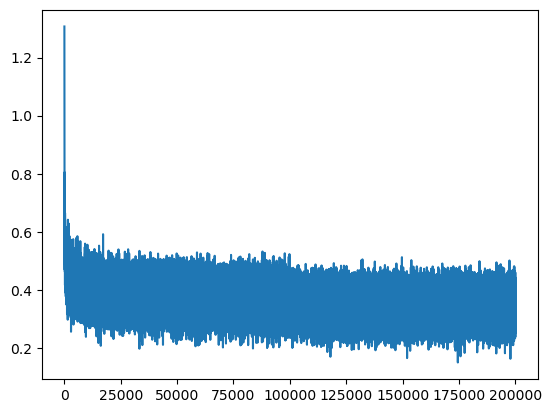

In [30]:
plt.plot(stepi, lossi)
plt.show() 

In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input_dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f'Training set loss={loss}')

Training set loss=2.236269950866699


In [32]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, input_dimensions) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(f'Validation set loss={loss}')

Validation set loss=2.2416956424713135


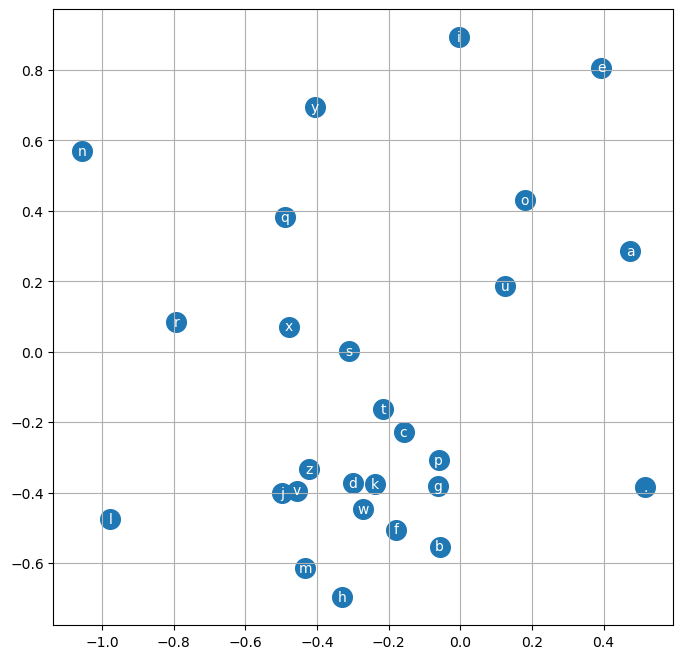

In [33]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=neuron_count)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

## Sample from model

In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)

      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mrix.
thaydencella.
jazhunn.
amerric.
kaqli.
nellaia.
ceriiv.
kaleig.
dham.
join.
quint.
suline.
livabi.
wazelogiearyn.
kak.
evidusabeed.
edi.
